In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/NVL Historical Data.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
18/18 [==============================] - 3s 76ms/step - loss: 0.1110 - val_loss: 0.0674
Epoch 2/100
18/18 [==============================] - 1s 57ms/step - loss: 0.0177 - val_loss: 0.0158
Epoch 3/100
18/18 [==============================] - 1s 76ms/step - loss: 0.0074 - val_loss: 0.0135
Epoch 4/100
18/18 [==============================] - 1s 81ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 5/100
18/18 [==============================] - 1s 81ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/100
18/18 [==============================] - 1s 47ms/step - loss: 5.6532e-04 - val_loss: 2.0722e-04
Epoch 7/100
18/18 [==============================] - 1s 45ms/step - loss: 4.9745e-04 - val_loss: 1.2527e-04
Epoch 8/100
18/18 [==============================] - 1s 45ms/step - loss: 4.7832e-04 - val_loss: 1.3816e-04
Epoch 9/100
18/18 [==============================] - 1s 45ms/step - loss: 4.6114e-04 - val_loss: 1.7375e-04
Epoch 10/100
18/18 [==============================] - 1s 46ms/step -

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

7/7 [==============================] - 0s 11ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 16306.176711748923


In [14]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.07842864841222763], [0.07727150619029999], [0.07568218559026718], [0.07387007027864456], [0.07191552966833115], [0.06985807418823242], [0.06772216409444809], [0.06552474200725555], [0.0632781907916069], [0.06099178269505501], [0.058672741055488586], [0.05632682517170906], [0.05395862087607384], [0.051571935415267944], [0.04916985705494881], [0.04675500467419624], [0.04432953521609306], [0.04189528152346611], [0.039453763514757156], [0.03700626268982887], [0.0345538854598999], [0.032097525894641876], [0.02963799238204956], [0.027175920084118843], [0.02471187897026539], [0.022246336564421654], [0.019779685884714127], [0.017312271520495415], [0.0148443803191185], [0.012376257218420506], [0.009908112697303295], [0.007440119981765747], [0.004972437862306833], [0.002505191368982196], [3.849761560559273e-05], [-0.0024275509640574455], [-0.004892861004918814], [-0.007357356604188681], [-0.009820973500609398], [-0.012283653020858765], [-0.014745330438017845], [-0.01720595732331276], [-0.019

In [15]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[16690.24689302],
       [16595.22700232],
       [16464.71835193],
       [16315.914691  ],
       [16155.41563424],
       [15986.46562004],
       [15811.07322678],
       [15630.62971467],
       [15446.15191504],
       [15258.40122779],
       [15067.97080451],
       [14875.3335758 ],
       [14680.86611186],
       [14484.88104856],
       [14287.63198192],
       [14089.33396383],
       [13890.1641138 ],
       [13690.27293758],
       [13489.78524478],
       [13288.80626704],
       [13087.42685843],
       [12885.72043636],
       [12683.75338244],
       [12481.57785363],
       [12279.24065352],
       [12076.78017332],
       [11874.22868611],
       [11671.61448818],
       [11468.96113428],
       [11266.28873775],
       [11063.61458225],
       [10860.95289242],
       [10658.3167075 ],
       [10455.71629446],
       [10253.1612702 ],
       [10050.65922504],
       [ 9848.21782572],
       [ 9645.84330509],
       [ 9443.54094002],
       [ 9241.31554854],


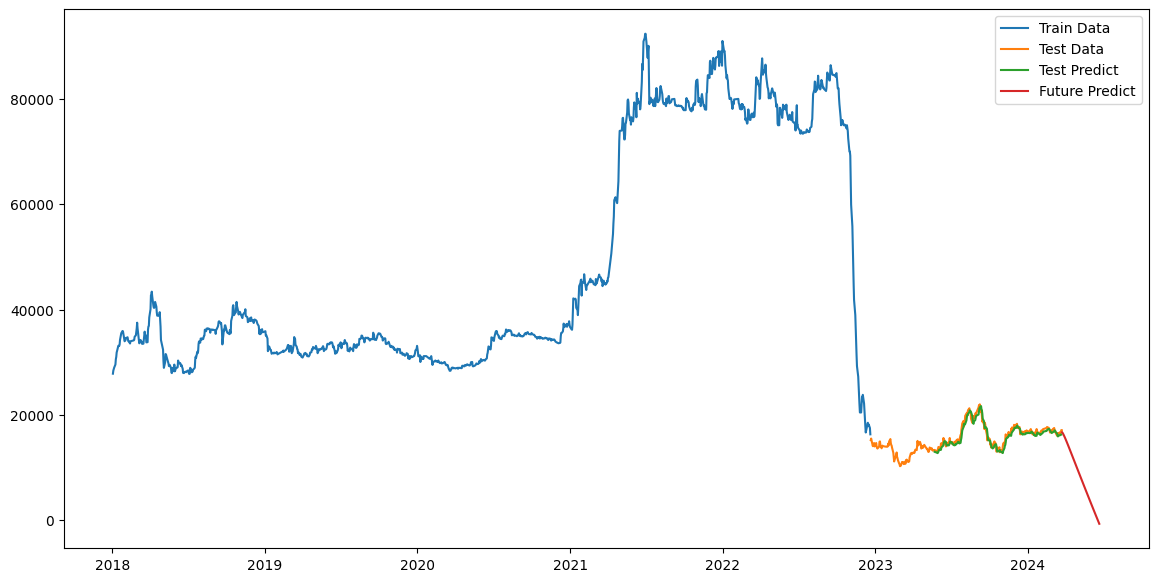

In [16]:
# Calculate future prediction dates
last_test_date = df['Date'].iloc[train_size + test_size - 1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=90)

# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:train_size + test_size], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data
plt.plot(df['Date'][train_size + time_step:train_size + test_size-1], y_pred, label='Test Predict')

# Plot future predictions
plt.plot(future_predict_dates, future_predict, label='Future Predict')


# Display the legend
plt.legend()

# Display the plot
plt.show()